In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    }
plt.rcParams.update(tex_fonts)

In [2]:
# read in data
df_PM10 = pd.read_csv('../air_weather_data/PM10_all_stations_cleaned.csv')
df_PM10['date'] = pd.to_datetime(df_PM10['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_PM10 = df_PM10.set_index('date') # date column as index

df_weather = pd.read_csv('../air_weather_data/metdata.csv')
df_weather['date'] = pd.to_datetime(df_weather['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_weather = df_weather.set_index('date') # date column as index

In [3]:
# drop negative and zero values and interpolate (in order to log transform)
df_PM10[df_PM10 <= 0] = np.NaN
df_PM10.interpolate(inplace=True)

In [4]:
# np.sum(df_PM10 <=0); # <-- testing if code above worked

In [5]:
# create lagged values
for i in df_PM10.columns:
    df_PM10[str(i) + ', lag1'] = df_PM10[i].shift(1)

# create lag2 for target station, also drop the NaN values
df_PM10['PM$_{10}$, Stockholm Torkel Knutssonsgatan, lag2'] = +\
    df_PM10['PM$_{10}$, Stockholm Torkel Knutssonsgatan'].shift(2)
df_PM10.dropna(inplace=True)

In [6]:
# split into train an test sets
df_PM10_train = df_PM10['2016-01-01':'2019-01-01']
df_PM10_test = df_PM10['2020-09-01':]

In [7]:
# log transform data
df_PM10_train = np.log(df_PM10_train)

In [8]:
# if only some stations are to be included
stations = [
            'PM$_{10}$, Stockholm Torkel Knutssonsgatan, lag1',
            'PM$_{10}$, Stockholm Torkel Knutssonsgatan, lag2',
            'PM$_{10}$, Stockholm Hornsgatan 108 , lag1',
            # 'PM$_{10}$, Stockholm Sveavägen 59 , lag1',
            'PM$_{10}$, Stockholm E4/E20 Lilla Essingen, lag1',
            'PM$_{10}$, Norr Malma, lag1',
            'PM$_{10}$, Sollentuna Ekmans Väg 11, lag1',
            ]

In [9]:
# create y and X matrix
y_train = df_PM10_train['PM$_{10}$, Stockholm Torkel Knutssonsgatan']
X_train = df_PM10_train[[i for i in df_PM10_train.columns if i[-4:-1] == 'lag']]
# possibility to exclude some stations
X_train = X_train[stations]
X_train.insert(0, 'intercept', 1) # insert a 1

In [10]:
# if temporal signals are to be included
X_train = X_train.merge(df_weather.iloc[:,6:8], on='date')

# if weather parameters are to be included
# X_train = X_train.merge(np.log(df_weather[['Relative humidity', 'Atmospheric pressure']]), on='date')

In [18]:
# fit OLS regression model
lmod = sm.OLS(y_train, X_train).fit()
print(lmod.summary())#.as_latex())

                                        OLS Regression Results                                        
Dep. Variable:     PM$_{10}$, Stockholm Torkel Knutssonsgatan   R-squared:                       0.765
Model:                                                    OLS   Adj. R-squared:                  0.765
Method:                                         Least Squares   F-statistic:                 1.073e+04
Date:                                        Sun, 14 Aug 2022   Prob (F-statistic):               0.00
Time:                                                01:54:24   Log-Likelihood:                -9929.0
No. Observations:                                       26328   AIC:                         1.988e+04
Df Residuals:                                           26319   BIC:                         1.995e+04
Df Model:                                                   8                                         
Covariance Type:                                    nonrobust            

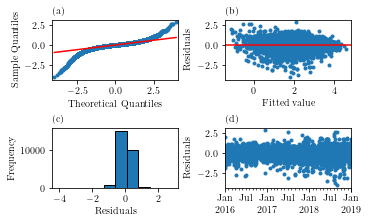

In [20]:
# PM10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (5, 3))

# QQ-plot of studentized residuals
sm.qqplot(lmod.resid, line='q', ax=ax1, marker=".")
ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod.fittedvalues, lmod.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")


ax3.hist(lmod.resid, edgecolor='black')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")

plt.savefig('../plots/Residual_plots_MLR_PM10.pdf')

In [13]:
# make new predictions
y_test = df_PM10_test['PM$_{10}$, Stockholm Torkel Knutssonsgatan'] # keep the target y in original scale
df_PM10_test = df_PM10_test.drop([i for i in df_PM10_test.columns if i[-4:-1] != 'lag'],axis=1) # only lagged values
df_PM10_test = np.log(df_PM10_test) # log transform test data
# possibility to exclude some stations
df_PM10_test = df_PM10_test[stations]
df_PM10_test.insert(0, 'intercept', 1) # insert column of ones in test data

In [14]:
# if temporal signals are to be included
df_PM10_test = df_PM10_test.merge(df_weather.iloc[:,6:8], on='date')

# if weather parameters are to be included
# df_PM10_test = df_PM10_test.merge(np.log(df_weather[['Relative humidity', 'Atmospheric pressure']]), on='date')

In [15]:
# check if columns in train and test matrices are same
all(df_PM10_test.columns == X_train.columns)

True

In [16]:
df_PM10_predictions = np.exp(lmod.get_prediction(df_PM10_test).summary_frame()) 
# df_PM10_predictions = lmod.get_prediction(df_PM10_test).summary_frame()

# print metrics
print('RMSE\n------------')
print('PM10, ', np.sqrt(mean_squared_error(df_PM10_predictions['mean'], y_test)).round(3))
print('\nMAPE:\n------------')
print('PM10, ', mean_absolute_percentage_error(df_PM10_predictions['mean'], y_test).round(3))

RMSE
------------
PM10,  3.692

MAPE:
------------
PM10,  0.306
